In [1]:
ROOT = '../'

In [2]:
EMBPATH = ROOT + 'data/embeddings/'

### Binary - Commenting Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/commenting/'

In [4]:
MPATH = ROOT + 'models/notebook4/commenting/'

In [5]:
!ls $DPATH

dev.csv  test.csv  train.csv


In [6]:
from glob import glob

In [7]:
ls = glob(DPATH + '*')
ls.sort()
devf, testf, trainf = ls

(devf, testf, trainf)

('../data/safecity/binary/commenting/dev.csv',
 '../data/safecity/binary/commenting/test.csv',
 '../data/safecity/binary/commenting/train.csv')

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv(devf)

In [10]:
df.head(4)

,Description,Category
0,Buses approaching to this place is highly unsafe.,1
1,a man was commenting at me.,1
2,in a share auto,0
3,I was coming out of a club at night with a few...,1


In [11]:
df['Description'].tolist()[:5]

['Buses approaching to this place is highly unsafe.',
 'a man was commenting at me.',
 'in a share auto',
 'I was coming out of a club at night with a few friends when a few guys came and stopped us and asked quotkya rate hai?quot When we shooed them away they kept following us.',
 'One of my friends was molested in the crowd. This happened on No 9 bridge of the Thane railway station.']

### Binary - Groping Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/groping/'

In [4]:
MPATH = ROOT + 'models/notebook4/groping/'

### Binary - Ogling Dataset

In [3]:
DPATH = ROOT + 'data/safecity/binary/ogling/'

In [4]:
MPATH = ROOT + 'models/notebook4/ogling/'

### Text Classifier

In [5]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.nn.utils import clip_grad_norm_
from torchtext import data, datasets, vocab

from sklearn.metrics import confusion_matrix

import random
import sys
import copy
from glob import glob
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
BATCH_SIZE = 64
CLIP_GRAD_NORM = 5

In [7]:
torch.cuda.device_count()

4

In [8]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [9]:
import re, string
import spacy

nlp = spacy.load('en_core_web_sm')
punctuation = string.punctuation
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def cleanup(text):
    """
    Tokenization/text cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)
    text = re.sub(r"\'s", " \'s", text)
    text = re.sub(r"\'ve", " \'ve", text)
    text = re.sub(r"n\'t", " n\'t", text)
    text = re.sub(r"\'re", " \'re", text)
    text = re.sub(r"\'d", " \'d", text)
    text = re.sub(r"\'ll", " \'ll", text)
    text = re.sub(r",", " , ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", " \( ", text)
    text = re.sub(r"\)", " \) ", text)
    text = re.sub(r"\?", " \? ", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip()

def tokenizer(sentence):
    sentence = cleanup(sentence) # regex cleanup  
    tokens = nlp(sentence, disable=['parser', 'tagger', 'ner']) # tokenizer
    tokens = [tok.lemma_.lower().strip() for tok in tokens if tok.lemma_ != '-PRON-'] # lemmatizer
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuation] # punctuation/stopword removal
    
    if not len(tokens):
        tokens += ['<pad>']
    return tokens

In [10]:
text_field = data.Field(batch_first=True, lower=True, tokenize=tokenizer)
label_field = data.LabelField(dtype=torch.float)

In [11]:
fields = [('Description', text_field), ('Category', label_field)] # order must be same as cols of csv
trainset, validset, testset = data.TabularDataset.splits(
                                        path=DPATH,
                                        train='train.csv',
                                        validation='dev.csv',
                                        test='test.csv',
                                        format='csv',
                                        fields=fields,
                                        skip_header=True)

print(f'Trainset length: {len(trainset)}')
print(f'Validset length: {len(validset)}')
print(f'Testset length: {len(testset)}')

Trainset length: 7201
Validset length: 990
Testset length: 1701


In [12]:
vars(trainset.examples[1])

{'Description': ['incident', 'place', 'metro', 'guy', 'start', 'stare'],
 'Category': '1'}

In [13]:
vecs = vocab.Vectors('glove.6B.300d.txt', EMBPATH)

text_field.build_vocab(trainset, validset, testset, vectors=vecs) 
label_field.build_vocab(trainset, validset, testset)

In [14]:
trainloader, validloader, testloader = data.BucketIterator.splits(
                                  (trainset, validset, testset), 
                                  batch_sizes=[BATCH_SIZE]*3,
                                  sort_key=lambda x: len(x.Description),
                                  sort_within_batch=True, 
                                  shuffle=True, 
                                  repeat=False,
                                  device=device)

print(f"Train DL length: {len(trainloader)}")
print(f"Valid DL length: {len(validloader)}")
print(f"Test DL length: {len(testloader)}")

Train DL length: 113
Valid DL length: 16
Test DL length: 27


In [15]:
n_tokens = len(text_field.vocab)
n_classes = len(label_field.vocab)

print(f"Number of tokens: {n_tokens}")
print(f"Number of classes: {n_classes}")

Number of tokens: 8103
Number of classes: 2


In [16]:
vars(label_field.vocab)

{'freqs': Counter({'0': 7778, '1': 2114}),
 'itos': ['0', '1'],
 'stoi': defaultdict(<function torchtext.vocab._default_unk_index()>,
             {'0': 0, '1': 1}),
 'vectors': None}

In [17]:
text_field.vocab.vectors.shape # n_tokens x embed_dim

torch.Size([8103, 300])

In [18]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, output_dim, dropout=0.4):
        super().__init__()
        
        # encoder
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim).from_pretrained(
                                        text_field.vocab.vectors) # freeze=True by default

        # recurrent layers (N stacked)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers,
                          dropout=dropout, bidirectional=True, batch_first=True)
        
        # decoder
        self.fc1 = nn.Linear(2*hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input x has shape (B, S) which is batch of sentences (sentence is list of word indices)
        emb = self.embedding(x) 
        emb = self.dropout(emb)
        # encoded input emb has shape (B, S, E)
        
        out, hidden = self.rnn(emb)
        # out.shape = (B, S, 2H)

        out = self.fc1(out[:, -1, :]) # decode the output of last time step (many-to-one), (B, 2H) to (B, H) to (B, 1)
        out = self.fc2(self.relu(self.dropout(out)))

        return out.squeeze(1) # out.shape = (B)

In [19]:
n_tokens, embed_dim = text_field.vocab.vectors.shape
(n_tokens, embed_dim)

(8103, 300)

In [20]:
kw = {
    'vocab_size': n_tokens,
    'embed_dim': embed_dim,
    'hidden_dim': 100,
    'n_layers': 2,
    'output_dim': 1
}
model = RNN(**kw)

model.to(device)

RNN(
  (embedding): Embedding(8103, 300)
  (rnn): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.4)
)

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, eps=1e-4, alpha=0.95, momentum=0.9, centered=True)

def accuracy(fx, y):
    ps = torch.sigmoid(fx)
    preds = torch.round(ps)
    return confusion_matrix(y.cpu().detach().view(-1), preds.cpu().detach().view(-1))

In [22]:
def train(model, iterator, criterion, optimizer, others=False):
    model.train()
    epoch_loss, epoch_acc = 0, 0

    for batch in iterator:
        x, y = batch.Description.to(device), batch.Category.to(device)
                
        fx = model(x)        
        loss = criterion(fx, y)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        optimizer.step()
        
        epoch_acc += accuracy(fx, y)
        epoch_loss += loss.item()
    
    epoch_loss /= len(iterator)
    
    tn, fp, fn, tp = epoch_acc.ravel()
    acc = (tp + tn)/(tp + tn + fp + fn)
    if others is False:
        return epoch_loss, acc

    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1 = 2*tp/(2*tp + fp + fn)
    return epoch_loss, acc, prec, rec, f1 

In [23]:
def evaluate(model, iterator, criterion, others=False):
    model.eval()
    epoch_loss, epoch_acc = 0, 0
    
    with torch.no_grad():
        for batch in iterator:
            x, y = batch.Description.to(device), batch.Category.to(device)
            
            fx = model(x)
            loss = criterion(fx, y)
            
            epoch_acc += accuracy(fx, y)
            epoch_loss += loss.item()

    epoch_loss /= len(iterator)
    
    tn, fp, fn, tp = epoch_acc.ravel()
    acc = (tp + tn)/(tp + tn + fp + fn)
    if others is False:
        return epoch_loss, acc

    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1 = 2*tp/(2*tp + fp + fn)
    return epoch_loss, acc, prec, rec, f1 

In [24]:
best_model = RNN(**kw).to(device)
best_name = None

### Commenting

In [32]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.5983 | Valid Loss: 0.4903 | Train Acc: 0.6898 | Valid Acc: 0.7768
Epoch: 02/30... | Train Loss: 0.4924 | Valid Loss: 0.4786 | Train Acc: 0.7829 | Valid Acc: 0.7909
Epoch: 03/30... | Train Loss: 0.4734 | Valid Loss: 0.4797 | Train Acc: 0.7949 | Valid Acc: 0.7980
Epoch: 04/30... | Train Loss: 0.4638 | Valid Loss: 0.4618 | Train Acc: 0.8041 | Valid Acc: 0.8051
Epoch: 05/30... | Train Loss: 0.4586 | Valid Loss: 0.4572 | Train Acc: 0.8003 | Valid Acc: 0.8051
Epoch: 06/30... | Train Loss: 0.4429 | Valid Loss: 0.4543 | Train Acc: 0.8132 | Valid Acc: 0.8081
Epoch: 07/30... | Train Loss: 0.4318 | Valid Loss: 0.4535 | Train Acc: 0.8166 | Valid Acc: 0.8020
Epoch: 08/30... | Train Loss: 0.4293 | Valid Loss: 0.4532 | Train Acc: 0.8163 | Valid Acc: 0.8071
Epoch: 09/30... | Train Loss: 0.4239 | Valid Loss: 0.4588 | Train Acc: 0.8204 | Valid Acc: 0.7990
Epoch: 10/30... | Train Loss: 0.4157 | Valid Loss: 0.4565 | Train Acc: 0.8266 | Valid Acc: 0.8030
Epoch: 11/30... | Tr

In [33]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-15-0.379-0.461-0.814.pt'

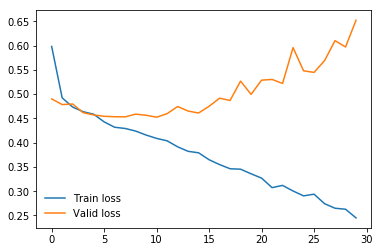

In [34]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 81.1%

In [15]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = RNN(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook4/commenting/model-15-0.379-0.461-0.814.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [16]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [19]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['pry', 'eye', 'morning', 'bus', 'station']
Indexed: [0, 313, 70, 9, 21]
Tensor (torch.Size([5])): tensor([  0, 313,  70,   9,  21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[  0, 313,  70,   9,  21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.0014], device='cuda:2')


0.26866769790649414

In [20]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['stalker', 'morning', 'bus', 'station']
Indexed: [2639, 70, 9, 21]
Tensor (torch.Size([4])): tensor([2639,   70,    9,   21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 4])): tensor([[2639,   70,    9,   21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.1449], device='cuda:2')


0.24142007529735565

In [21]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['person', 'follow', 'night', 'try', 'sexually', 'harass']
Indexed: [72, 16, 35, 13, 118, 65]
Tensor (torch.Size([6])): tensor([ 72,  16,  35,  13, 118,  65], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 72,  16,  35,  13, 118,  65]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-0.8172], device='cuda:2')


0.3063642382621765

In [22]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['people', 'pass', 'lewd', 'remark', 'young', 'lady']
Indexed: [32, 14, 178, 347, 116, 66]
Tensor (torch.Size([6])): tensor([ 32,  14, 178, 347, 116,  66], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 32,  14, 178, 347, 116,  66]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([1.9482], device='cuda:2')


0.8752530217170715

In [23]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['person', 'grab', 'woman', "'s", 'pubis', 'park']
Indexed: [72, 140, 50, 44, 6789, 124]
Tensor (torch.Size([6])): tensor([  72,  140,   50,   44, 6789,  124], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[  72,  140,   50,   44, 6789,  124]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-3.2842], device='cuda:2')


0.03611721098423004

### Groping

In [25]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.5377 | Valid Loss: 0.4312 | Train Acc: 0.7453 | Valid Acc: 0.8152
Epoch: 02/30... | Train Loss: 0.3965 | Valid Loss: 0.3805 | Train Acc: 0.8406 | Valid Acc: 0.8566
Epoch: 03/30... | Train Loss: 0.3803 | Valid Loss: 0.3844 | Train Acc: 0.8525 | Valid Acc: 0.8586
Epoch: 04/30... | Train Loss: 0.3638 | Valid Loss: 0.3713 | Train Acc: 0.8588 | Valid Acc: 0.8505
Epoch: 05/30... | Train Loss: 0.3619 | Valid Loss: 0.3805 | Train Acc: 0.8582 | Valid Acc: 0.8374
Epoch: 06/30... | Train Loss: 0.3385 | Valid Loss: 0.3646 | Train Acc: 0.8684 | Valid Acc: 0.8485
Epoch: 07/30... | Train Loss: 0.3381 | Valid Loss: 0.3700 | Train Acc: 0.8685 | Valid Acc: 0.8545
Epoch: 08/30... | Train Loss: 0.3296 | Valid Loss: 0.3606 | Train Acc: 0.8722 | Valid Acc: 0.8596
Epoch: 09/30... | Train Loss: 0.3106 | Valid Loss: 0.3555 | Train Acc: 0.8786 | Valid Acc: 0.8535
Epoch: 10/30... | Train Loss: 0.3109 | Valid Loss: 0.3525 | Train Acc: 0.8814 | Valid Acc: 0.8586
Epoch: 11/30... | Tr

In [26]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-18-0.246-0.396-0.863.pt'

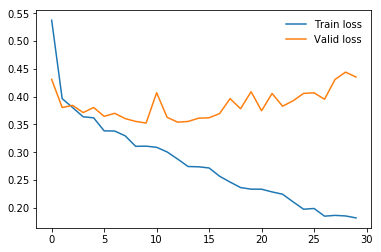

In [27]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 86.5%

In [18]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = RNN(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook4/groping/model-18-0.246-0.396-0.863.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [20]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['pry', 'eye', 'morning', 'bus', 'station']
Indexed: [0, 313, 70, 9, 21]
Tensor (torch.Size([5])): tensor([  0, 313,  70,   9,  21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[  0, 313,  70,   9,  21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-2.9401], device='cuda:2')


0.050208836793899536

In [22]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['stalker', 'morning', 'bus', 'station']
Indexed: [2639, 70, 9, 21]
Tensor (torch.Size([4])): tensor([2639,   70,    9,   21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 4])): tensor([[2639,   70,    9,   21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([0.1587], device='cuda:2')


0.5395882725715637

In [23]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['person', 'follow', 'night', 'try', 'sexually', 'harass']
Indexed: [72, 16, 35, 13, 118, 65]
Tensor (torch.Size([6])): tensor([ 72,  16,  35,  13, 118,  65], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 72,  16,  35,  13, 118,  65]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([0.9875], device='cuda:2')


0.7286012768745422

In [24]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['people', 'pass', 'lewd', 'remark', 'young', 'lady']
Indexed: [32, 14, 178, 347, 116, 66]
Tensor (torch.Size([6])): tensor([ 32,  14, 178, 347, 116,  66], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 32,  14, 178, 347, 116,  66]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-5.9214], device='cuda:2')


0.002674328163266182

In [25]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['person', 'grab', 'woman', "'s", 'pubis', 'park']
Indexed: [72, 140, 50, 44, 6789, 124]
Tensor (torch.Size([6])): tensor([  72,  140,   50,   44, 6789,  124], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[  72,  140,   50,   44, 6789,  124]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([4.7070], device='cuda:2')


0.9910492897033691

### Ogling

In [25]:
EPOCHS = 30
best_valid_acc = 0

train_losses = []
valid_losses = []

for e in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, validloader, criterion)

    # model progress
    print(f"Epoch: {e:02}/{EPOCHS}... "
          f"| Train Loss: {train_loss:.4f} "
          f"| Valid Loss: {valid_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} "
          f"| Valid Acc: {valid_acc:.4f}")
    
    if best_valid_acc < valid_acc:
        best_valid_acc = valid_acc

        filename = f'model-{e:02}-{train_loss:.3f}-{valid_loss:.3f}-{valid_acc:.3f}.pt'
#         torch.save(model.state_dict(), MPATH + filename)
        
        best_model.load_state_dict(model.state_dict())
        best_name = filename
    
    # for model complexity graph
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

print('Done\n')
vl, vacc, vprec, vrec, vf1 = evaluate(best_model, validloader, criterion, others=True)
print(f'Valid: Loss {vl:.4f} | Acc {vacc:.4f} | Prec {vprec:.4f} | Rec {vrec:.4f} | F1 {vf1:.4f}')
tl, tacc, tprec, trec, tf1 = evaluate(best_model, testloader, criterion, others=True)
print(f'Test : Loss {tl:.4f} | Acc {tacc:.4f} | Prec {tprec:.4f} | Rec {trec:.4f} | F1 {tf1:.4f}')

Epoch: 01/30... | Train Loss: 0.5207 | Valid Loss: 0.4595 | Train Acc: 0.7860 | Valid Acc: 0.8071
Epoch: 02/30... | Train Loss: 0.4551 | Valid Loss: 0.4310 | Train Acc: 0.8209 | Valid Acc: 0.8273
Epoch: 03/30... | Train Loss: 0.4510 | Valid Loss: 0.4288 | Train Acc: 0.8213 | Valid Acc: 0.8333
Epoch: 04/30... | Train Loss: 0.4324 | Valid Loss: 0.4245 | Train Acc: 0.8307 | Valid Acc: 0.8364
Epoch: 05/30... | Train Loss: 0.4240 | Valid Loss: 0.4948 | Train Acc: 0.8334 | Valid Acc: 0.8030
Epoch: 06/30... | Train Loss: 0.4274 | Valid Loss: 0.4245 | Train Acc: 0.8266 | Valid Acc: 0.8364
Epoch: 07/30... | Train Loss: 0.4097 | Valid Loss: 0.4318 | Train Acc: 0.8368 | Valid Acc: 0.8343
Epoch: 08/30... | Train Loss: 0.3981 | Valid Loss: 0.4187 | Train Acc: 0.8384 | Valid Acc: 0.8374
Epoch: 09/30... | Train Loss: 0.3926 | Valid Loss: 0.4354 | Train Acc: 0.8404 | Valid Acc: 0.8293
Epoch: 10/30... | Train Loss: 0.3902 | Valid Loss: 0.4211 | Train Acc: 0.8400 | Valid Acc: 0.8364
Epoch: 11/30... | Tr

In [26]:
torch.save(best_model.state_dict(), MPATH + best_name)
best_name

'model-17-0.341-0.463-0.840.pt'

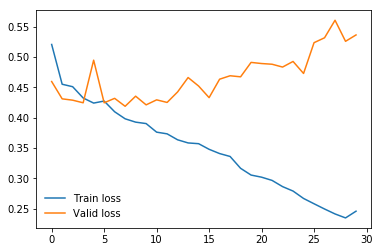

In [27]:
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)

# Time: 5s per epoch
# Accuracy: 83.1%

In [21]:
ls = glob(MPATH + '*')
ls.sort()
filename = ls[-1]
print(filename)

model = RNN(**kw).to(device)

model.load_state_dict(torch.load(filename, map_location=device))

../models/notebook4/ogling/model-17-0.341-0.463-0.840.pt


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [22]:
def predict(sentence):
    tokenized = tokenizer(sentence)
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    
    print(f'Tokenized: {tokenized}')
    print(f'Indexed: {indexed}')
    print(f'Tensor ({tensor.shape}): {tensor}')
    
    tensor = tensor.unsqueeze(0) # as we have used batch_first=True
    with torch.no_grad():
        model.eval()
        fx = model(tensor)

    print(f'Tensor w/ batch_size ({tensor.shape}): {tensor}')
    print(f'Logit Tensor ({fx.shape}): {fx}')
    return torch.sigmoid(fx).item()

In [23]:
predict("I had prying eyes on me this morning at the bus station")

Tokenized: ['pry', 'eye', 'morning', 'bus', 'station']
Indexed: [0, 313, 70, 9, 21]
Tensor (torch.Size([5])): tensor([  0, 313,  70,   9,  21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 5])): tensor([[  0, 313,  70,   9,  21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-0.4233], device='cuda:2')


0.3957330286502838

In [24]:
predict("I had a stalker this morning at the bus station")

Tokenized: ['stalker', 'morning', 'bus', 'station']
Indexed: [2639, 70, 9, 21]
Tensor (torch.Size([4])): tensor([2639,   70,    9,   21], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 4])): tensor([[2639,   70,    9,   21]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-2.0518], device='cuda:2')


0.1138712614774704

In [25]:
predict("This person followed me at night and tried to sexually harass me")

Tokenized: ['person', 'follow', 'night', 'try', 'sexually', 'harass']
Indexed: [72, 16, 35, 13, 118, 65]
Tensor (torch.Size([6])): tensor([ 72,  16,  35,  13, 118,  65], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 72,  16,  35,  13, 118,  65]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-1.8613], device='cuda:2')


0.13455316424369812

In [26]:
predict("There were quite a few people passing lewd remarks at a young lady")

Tokenized: ['people', 'pass', 'lewd', 'remark', 'young', 'lady']
Indexed: [32, 14, 178, 347, 116, 66]
Tensor (torch.Size([6])): tensor([ 32,  14, 178, 347, 116,  66], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[ 32,  14, 178, 347, 116,  66]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-3.5714], device='cuda:2')


0.027346407994627953

In [27]:
predict("The person grabbed the woman's pubes in the park")

Tokenized: ['person', 'grab', 'woman', "'s", 'pubis', 'park']
Indexed: [72, 140, 50, 44, 6789, 124]
Tensor (torch.Size([6])): tensor([  72,  140,   50,   44, 6789,  124], device='cuda:2')
Tensor w/ batch_size (torch.Size([1, 6])): tensor([[  72,  140,   50,   44, 6789,  124]], device='cuda:2')
Logit Tensor (torch.Size([1])): tensor([-5.2345], device='cuda:2')


0.005301336757838726